# Soft decision tree

## Decision Tree
* Decision Tree는 각각의 node에서 하나의 변수를 기준으로 순차적으로 2개 혹은 그 이상의 그룹으로 나누는 모형
    * 최초 시작점을 Root, 가지의 말단을 leaf node, Root와 leaf node 사이의 node들을 inner node라고 부름
    * 그렇게 굳이 나누어 부르는 이유는 Leaf node와 inner node의 역할이 조금 다를 수 있기 때문임
    * 두개의 layer만 고려할 때에는 어떤 기준에 의해 갈라지기 전의 node를 parent node, 갈라진 후의 node들을 child node라고 얘기한다.
    * 각 node에서는 Node에서는 측정된 impurity가 가장 작은 split point들을 grid search를 통해 순차적으로 찾아가는데, impurity는 다음과 같이 정의된다.
         * Gini impurity는 CART에서 사용한 개념으로 다음과 같이 정의된다. (J개의 class를 가지고 있고, 각 $p_i, i = 1, \ldots, J$는 주어진 leaf node들이 각 class에 속하는 비율로 계산한다.)
    $$I_{G}(p)=\sum _{i=1}^{J}p_{i}\sum _{k\neq i}p_{k}=\sum _{i=1}^{J}p_{i}(1-p_{i})=\sum _{i=1}^{J}(p_{i}-{p_{i}}^{2})=\sum _{i=1}^{J}p_{i}-\sum _{i=1}^{J}{p_{i}}^{2}=1-\sum _{i=1}^{J}{p_{i}}^{2}$$
         *  ID3, C4.5 and C5.0에서는 부모 node의 정보량(Information)에 비해 자식 node들의 정보량 (각 node의 Information의 해당 child node에 분배된 sample의 갯수를 기준으로한 가중 평균)이 얼마나 크게 늘었는지를 측정하는 Information gain을 사용한다.
             * NOTE: Information은 정보이론에서 차용한 entropy라는 개념으로, 불확실성이 가장 큰 경우 가장 큰 값을 가지며, 다음과 같이 정의 된다. 여기서도 각 $p_i$는 주어진 node에 속한 data의 emprical probability를 의미한다.
         $$H(T)=I_{E}(p_{1},p_{2},...,p_{J})=-\sum _{i=1}^{J}p_{i}\log _{2}^{}p_{i}$$
             * 부모 node, 자식 node에서 각각 정보량을 구한 후에 Information gain은 다음과 같이 구한다
         $$ \overbrace {IG(T,a)} ^{\text{Information Gain}}=\overbrace {H(T)} ^{\text{Entropy(parent)}}-\overbrace {H(T|a)} ^{\text{Weighted Sum of Entropy(Children)}}$$
        
        * CART에서는 Continuous variable을 분류할 수도 있는데, 이 경우에는 부모 node와 자식 node의 variance 변동을 최대화하는 split point를 선택한다.
        $$I_{V}(N)={\frac {1}{|S|^{2}}}\sum _{i\in S}\sum _{j\in S}{\frac {1}{2}}(x_{i}-x_{j})^{2}-\left({\frac {1}{|S_{t}|^{2}}}\sum _{i\in S_{t}}\sum _{j\in S_{t}}{\frac {1}{2}}(x_{i}-x_{j})^{2}+{\frac {1}{|S_{f}|^{2}}}\sum _{i\in S_{f}}\sum _{j\in S_{f}}{\frac {1}{2}}(x_{i}-x_{j})^{2}\right)$$

## Soft Decision Tree
  * Soft Decision Tree의 핵심 개념은, 전통적인 tree 모형에서는 하나의 node에서는 하나의 변수에 의해 하나의 split point를 기준으로 관측치를 분류하였다면,
    * soft decision tree는 split point를 정의함에 있어서 ** 여러변수를 동시에 사용**하면서 분류의 강도를 표현할 수 있도록, **sigmoid**함수를 사용한다는 점이다.


## Apply DNN to decision tree

# Load Libreary

In [1]:
import os
import time
import pickle
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from tqdm import tqdm, tqdm_notebook

gpu_ctx = mx.gpu(0)
cpu_ctx = mx.cpu(0)

/home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


# Load Data

In [2]:
mnist = mx.test_utils.get_mnist()
#print(mnist['train_data'][0].shape)

train_data = np.reshape(mnist['train_data'],(-1,28*28))
test_data = np.reshape(mnist['test_data'],(-1,28*28))

batch_size = 100
OUT_DIM = 10
n_batches = train_data.shape[0]/batch_size
train_iter = mx.io.NDArrayIter(data={'data': train_data}, label={'label': mnist['train_label']}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': test_data}, label={'label': mnist['test_label']}, batch_size = batch_size)

# Define Function

In [17]:
class InnerNode(gluon.Block):
    def __init__(self, depth, super_node_name, node_name, **kwargs):
        super(InnerNode, self).__init__()
        self.kwargs = kwargs
        with self.name_scope():
            # Parameter
            self.fc = gluon.nn.Dense(units = 1, activation = None)
            self.beta = mx.nd.random.normal()
            self.beta.attach_grad()
        
        # 각 node가 지니고 있어야 하는 모형관련 정보
        self.data = None # Node에 속하는 data
        self.leaf = False # Leaf node 여부 (Leaf node에서는 loss를 계산해야 함)
        self.prob = None # FC를 통해 얻어진 확률
        self.penalties = []
        self.path_prob = None
        self.lmbd = self.kwargs['lmbd'] * 2 ** (-depth)
        
        # Layer specific 정보
        self.depth = depth
        self.super_node_name = super_node_name
        # 각 node의 이름 설정 (나중에 debugging에 용이함)
        if depth == 1:
            self.node_name = node_name
        else:
            self.node_name = super_node_name + ':' + node_name
        
        # constructor가 실행되는 순간 child node 생성
        self.build_child(depth) 
        
    def reset(self):
        self.data = None # Node에 속하는 data
        self.leaf = None # Leaf node 여부 (Leaf node에서는 loss를 계산해야 함)
        self.prob = None # FC를 통해 얻어진 확률
        self.penalties = []
        self.left.reset()
        self.right.reset()
       
    def build_child(self, depth):
        # 만약 max_depth보다 depth가 작지 않으면 child node 대신 Leaf node 생성
        # Binary 문제이므로, 2개의 child node가 생성됨
        if depth < self.kwargs['max_depth']:
            self.left = InnerNode(depth + 1, self.node_name, 'left', **self.kwargs)
            self.right = InnerNode(depth + 1, self.node_name, 'right', **self.kwargs)
        else:
            self.left = LeafNode(self.node_name, 'l_leaf', **self.kwargs)
            self.right = LeafNode(self.node_name, 'r_leaf', **self.kwargs)
            
    def forward(self, x, label, path_prob):
        # Label을 같이 가져와서 loss를 구하기
        # 현재 Node의 data를 저장
        self.data = x
        self.label = label
        self.path_prob = path_prob
        # Network를 학습
        # Recursive하게 확률을 update 해나가는 것이므로, Leaf_node의 method와 이름이 같아야 함
        # 최종 Leaf node에서 나오는 path_probability와 predicted distribution Q를 저장함
        # 현재 node에서 확률값 계산
        self.prob = nd.sigmoid(self.beta.as_in_context(self.kwargs['ctx'])*self.fc(self.data)) #self.beta.as_in_context(self.ctx)* #일단은 beta제외
        #self.prob = nd.sigmoid(self.fc(self.data)) #self.beta.as_in_context(self.ctx)* #일단은 beta제외
        
        # 확률값에 따라 left, right node로 나누어서 저장
        # nd array가 slicing이 잘 안돼서, numpy로 바꾸었다가 다시 ndarray로 바꾸는 과정을 거침
        # member 변수로 해야만 child node에서 사용이 가능
        self.l_idx = (self.prob.asnumpy().reshape((len(self.prob))) <= self.kwargs['cut_off'])
        self.r_idx = (self.prob.asnumpy().reshape((len(self.prob))) > self.kwargs['cut_off'])
        
        # Split data into children
        left_data = nd.array(self.data.asnumpy()[self.l_idx, :], ctx = self.kwargs['ctx'])
        left_label = nd.array(self.label.asnumpy()[self.l_idx], ctx = self.kwargs['ctx'])
        left_data_prob = nd.array(self.prob.asnumpy()[self.l_idx], ctx = self.kwargs['ctx'])
        left_path_prob = nd.array(self.path_prob.asnumpy()[self.l_idx], ctx = self.kwargs['ctx'])
        
        right_data = nd.array(self.data.asnumpy()[self.r_idx, :], ctx = self.kwargs['ctx'])
        right_label = nd.array(self.label.asnumpy()[self.r_idx], ctx = self.kwargs['ctx'])
        right_data_prob = nd.array(self.prob.asnumpy()[self.r_idx], ctx = self.kwargs['ctx'])
        right_path_prob = nd.array(self.path_prob.asnumpy()[self.r_idx], ctx = self.kwargs['ctx'])
        
        # Forward children
        if left_data is not None and len(left_path_prob) > 0:
            self.left(left_data, left_label, left_path_prob * (1 - left_data_prob))
        if right_data is not None and len(right_path_prob) > 0:
            self.right(right_data, right_label, right_path_prob * right_data_prob)
                  
    # Node별 penalty term 계산하기
    # 좌나 우로 너무 쏠리지 않게 하는 역할
    # Leaf node가 아닌 경우에만 계산
    def get_penalty(self):
        alpha = nd.sum(self.prob * self.path_prob) / nd.sum(self.path_prob)
        penalty = - self.lmbd * 0.5 * (nd.log(alpha) + nd.log(1 - alpha))
        if not self.leaf:      
            left_penalty = self.left.get_penalty()
            right_penalty = self.right.get_penalty()  
            self.penalties.extend(penalty)
            self.penalties.extend(left_penalty)
            self.penalties.extend(right_penalty)
        return(self.penalties)

            
    
    # 실제 target과의 비교를 통해서 loss를 계산
    # Leaf node에 대해서만 계산
    def get_loss(self, loss = 0):
        # 재귀호출을 위해서...
        loss = self.left.get_loss(loss)
        loss = self.right.get_loss(loss)
        return loss
    
    def print_node_info(self):
        print('node name = {}, data size = {}'.format(self.super_node_name + self.node_name, self.data.shape))

In [18]:
class LeafNode(gluon.Block):
    def __init__(self, super_node_name, node_name, **kwargs):
        super(LeafNode, self).__init__()
        self.kwargs = kwargs
        with self.name_scope():
            self.par = mx.nd.random_normal(shape = (self.kwargs['output_dim'])
                                         , loc = 0, scale = 1., ctx = self.kwargs['ctx'])
            self.par.attach_grad()
        
        self.path = super_node_name
        self.node_name = node_name
        self.leaf = True
        self.path_prob = None
        self.x = None
        self.loss = 0
        
    def forward(self, x, label, path_prob):
        # 최종 결과 node는 우리가 classify하고자 하는 class의 갯수
        # 각 관측치가 가지고 있는, root로부터 leaf에 이르기까지 각 단계의 확률의  
        # one-hot labeling
        self.Q = nd.softmax(self.par)
        self.path_prob = path_prob
        target = np.zeros((label.shape[0], self.kwargs['output_dim']))
        target[np.arange(label.shape[0]), [int(x) for x in label.asnumpy()]] = 1
        self.target = nd.array(target).as_in_context(self.kwargs['ctx'])
        
        self.loss = - nd.sum(self.path_prob * nd.sum( self.target * nd.log(self.Q + 1e-10), axis = 1).expand_dims(1))

    def get_penalty(self):
        return [0]
    
    def print_node_info(self):
        print('node name = {}, loss = {}'.format(self.super_node_name + node_name, self.loss))
        
    def get_loss(self, loss):
        if self.loss is not None:
            return loss + self.loss
        else:
            return loss
    
    def reset(self):
        self.loss = 0
        pass

## Sample data

In [19]:
train_iter.reset()
test_iter.reset()
    
n_batch_train = 0
for batch in train_iter:
    n_batch_train +=1
    data = batch.data[0]
    label = batch.label[0]
    if n_batch_train == 1:
        break

In [20]:
args = {}
args['lmbd'] = .5
args['output_dim'] = 10
args['ctx'] = gpu_ctx
args['cut_off'] = .5
args['max_depth'] = 2

tree = InnerNode(0, '', 'root', **args)
tree.collect_params().initialize(mx.init.Xavier(), ctx = args['ctx'])

In [21]:
# probability의 shape이 (batch_size, 1)이므로, 이에 맞도록 dimension을 하나 늘려줌
prob = nd.ones(shape = (data.shape[0]), ctx = gpu_ctx).expand_dims(1)
tree(data.as_in_context(gpu_ctx), label.as_in_context(gpu_ctx), prob)

In [22]:
tree.prob[:10]


[[ 0.42400083]
 [ 0.53684336]
 [ 0.52593756]
 [ 0.40231487]
 [ 0.4623878 ]
 [ 0.41055611]
 [ 0.48722276]
 [ 0.44295362]
 [ 0.4563134 ]
 [ 0.48843241]]
<NDArray 10x1 @gpu(0)>

In [23]:
pp = tree.get_penalty()

In [24]:
pp

[
 [ 0.34824646]
 <NDArray 1 @gpu(0)>, 
 [ 0.17910001]
 <NDArray 1 @gpu(0)>, 
 [ 0.08711782]
 <NDArray 1 @gpu(0)>, 0, 0, 
 [ 0.08664767]
 <NDArray 1 @gpu(0)>, 0, 0, 
 [ 0.17331734]
 <NDArray 1 @gpu(0)>, 
 [ 0.08889298]
 <NDArray 1 @gpu(0)>, 0, 0, 
 [ 0.08664359]
 <NDArray 1 @gpu(0)>, 0, 0]

In [25]:
pen = 0
for p in pp:
    pen += p
pen


[ 1.04996598]
<NDArray 1 @gpu(0)>

In [26]:
0.35175842+ 0.17332152 + 0.08713116 + 0.08668289 + 0.1749732 + 0.0867621 + 0.08785879

1.0484880799999998

In [27]:
tree.get_loss(0)


[ 49.65241623]
<NDArray 1 @gpu(0)>

In [28]:
(tree.left.left.left.loss)+\
(tree.left.left.right.loss)+\
(tree.left.right.left.loss)+\
(tree.left.right.right.loss)+\
(tree.right.left.left.loss)+\
(tree.right.left.right.loss)+\
(tree.right.right.left.loss)+\
(tree.right.right.right.loss)



[ 49.65241623]
<NDArray 1 @gpu(0)>

## Trainer

In [29]:
trainer = gluon.Trainer(tree.collect_params(), 'adam', {'learning_rate': .001})

# Training

In [31]:
n_epoch = 100
print_period = n_epoch // 50
start = time.time()

training_loss = []
validation_loss = []
for epoch in tqdm_notebook(range(n_epoch), desc='epochs'):
    epoch_loss = 0
    epoch_val_loss = 0
    
    train_iter.reset()
    test_iter.reset()
    
    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(gpu_ctx)
        label = batch.label[0].as_in_context(gpu_ctx)
        with autograd.record():
            tree.reset()
            prob = nd.ones(shape = (data.shape[0]), ctx = gpu_ctx).expand_dims(1)
            tree(data, label, prob)
            loss = tree.get_loss(0)
            tree.get_penalty()
            penalty = 0
            for t in tree.penalties:
                penalty = penalty + t
            pen_loss = loss + penalty
        pen_loss.backward()
        #print('data size = {}'.format(data[:5, :5]))
        # Parameter 중에 update가 되지 않는 parameter를 무시하는 옵션
        # 모든 leafnode에 data가 존재하지 않을 수 있으므로, True로 설정(?!)
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()
    
    n_batch_val = 0
    for batch in test_iter:
        tree.reset()
        n_batch_val +=1
        data = batch.data[0].as_in_context(gpu_ctx)
        label = batch.label[0].as_in_context(gpu_ctx)
        prob = nd.ones(shape = (data.shape[0]), ctx = gpu_ctx).expand_dims(1)
        tree(data, label, prob)
        loss = tree.get_loss(0) 
        tree.get_penalty()
        penalty = 0
        for t in tree.penalties:
            penalty = penalty + t
        pen_loss = loss + penalty
        epoch_val_loss += nd.mean(pen_loss).asscalar()
        
    
    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val
    
    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)
    
    if epoch % max(print_period,1) == 0:
        tqdm.write('Epoch %d, Training loss %s, Validation loss %s' % (epoch, epoch_loss, epoch_val_loss))
        
end = time.time()
tqdm.write('Time elapsed: {:.2f}s'.format(end - start))

A Jupyter Widget

Epoch 0, Training loss 39.0575924238, Validation loss 38.9634684372
Epoch 5, Training loss 38.8517271487, Validation loss 42.1213698959


KeyboardInterrupt: 

In [40]:
max_Q = nd.max(tree.left.left.left.Q)

In [43]:
max_Q
Q= tree.left.left.left.Q
pred = [x for x in range(len(Q)) if Q[x] == max_Q]

[8]

In [44]:
tree(x)

InnerNode(
  (fc): Dense(784 -> 1, linear)
  (left): InnerNode(
    (fc): Dense(784 -> 1, linear)
    (left): InnerNode(
      (fc): Dense(784 -> 1, linear)
      (left): LeafNode(
      
      )
      (right): LeafNode(
      
      )
    )
    (right): InnerNode(
      (fc): Dense(784 -> 1, linear)
      (left): LeafNode(
      
      )
      (right): LeafNode(
      
      )
    )
  )
  (right): InnerNode(
    (fc): Dense(784 -> 1, linear)
    (left): InnerNode(
      (fc): Dense(784 -> 1, linear)
      (left): LeafNode(
      
      )
      (right): LeafNode(
      
      )
    )
    (right): InnerNode(
      (fc): Dense(784 -> 1, linear)
      (left): LeafNode(
      
      )
      (right): LeafNode(
      
      )
    )
  )
)

In [461]:
# Plotting library
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.models import Range1d
from bokeh.palettes import brewer

output_notebook()

color_map = brewer["Spectral"][10]
batch_x = np.linspace(1, n_epoch, len(training_loss))
p = figure(plot_width=400, plot_height=400)
p.line(batch_x, training_loss, color = color_map[0], line_width=2)
p.line(batch_x, validation_loss, color = color_map[1], line_width=2)
show(p)

Loading BokehJS ...

# Inspect results

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1st Layer

<module 'matplotlib.pyplot' from '/home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/matplotlib/pyplot.py'>

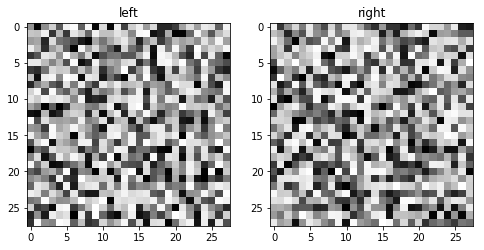

In [16]:
_, axarr = plt.subplots(1, 2, figsize=(8,4))
axarr[0].imshow(tree.left.fc.weight.data().reshape((28, 28)).asnumpy(), cmap='Greys')
axarr[0].set_title('left')
axarr[1].imshow(tree.right.fc.weight.data().reshape((28, 28)).asnumpy(), cmap='Greys')
axarr[1].set_title('right')
plt

## 2nd Layer

<module 'matplotlib.pyplot' from '/home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/matplotlib/pyplot.py'>

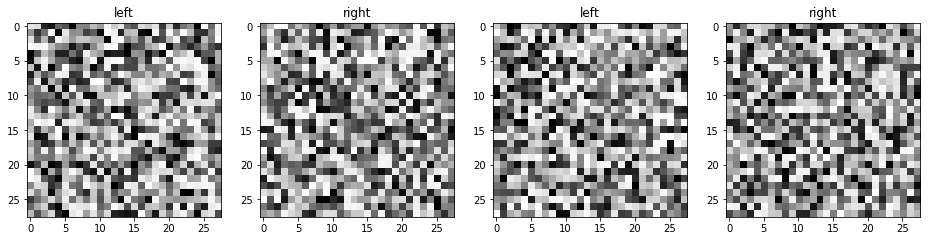

In [17]:
_, axarr = plt.subplots(1, 4, figsize=(16,4))
axarr[0].imshow(tree.left.left.fc.weight.data().reshape((28, 28)).asnumpy(), cmap='Greys')
axarr[0].set_title('left')
axarr[1].imshow(tree.left.right.fc.weight.data().reshape((28, 28)).asnumpy(), cmap='Greys')
axarr[1].set_title('right')
axarr[2].imshow(tree.right.left.fc.weight.data().reshape((28, 28)).asnumpy(), cmap='Greys')
axarr[2].set_title('left')
axarr[3].imshow(tree.right.right.fc.weight.data().reshape((28, 28)).asnumpy(), cmap='Greys')
axarr[3].set_title('right')
plt